Jeopardy is a popular TV show in the US where participants answer questions to win money. In this project, we will work with the dataset of Jeopardy questions to figure out some patterns in the questions that could help win the game.<br>

The dataset can be found at this <a href=https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/>link</a><br>
Each row in the dataset corresponds to one questions asked on a single episode. Description of a few columns :-

    
    Show Number - the Jeopardy episode number of the show this question was in.
    Air Date - the date the episode aired.
    Round - the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
    Category - the category of the question.
    Value - the number of dollars answering the question correctly is worth.
    Question - the text of the question.
    Answer - the text of the answer.
    
    



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from scipy.stats import chisquare,chi2_contingency
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/hp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/hp/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
df = pd.read_csv('jeopardy.csv')
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

We will firstly clean the column names for our ease of usage throughout the project.

In [4]:
cols = df.columns
df.columns = cols.str.strip().str.lower().str.replace(" ","_")
df.head(3)

,show_number,air_date,round,category,value,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
show_number    19999 non-null int64
air_date       19999 non-null object
round          19999 non-null object
category       19999 non-null object
value          19999 non-null object
question       19999 non-null object
answer         19999 non-null object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


Let us normalize the questions and ansewrs columns to remove punctuations and convert all words to lower case. Some questions also contains html tags, so we will remove them as well. This way we can easily use the words for comparision later on.

In [23]:
def clean_text(row):
    row = re.sub(r'<.*?>',' ',row)
    row = re.sub(r'\W',' ',row)
    row = row.strip().lower()
    return row

df['clean_question'] = df.question.apply(clean_text)
df['clean_answer'] = df.answer.apply(clean_text)
df.head(3)

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was ...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisl...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona


The value column must be numeric and the air_date a `datetime` object rather than a string. So let us normalize these as well.

In [6]:
df.value = df.value.str.replace("[$,]","").str.strip()
df.value.sample(10,random_state=2) 
#Sample only to get random data points and show a None

836      None
1849     2000
7278     3000
527      1600
10432    1000
1497      400
16621     400
5043      200
12247     200
9031      200
Name: value, dtype: object

We see there are some rows that have 'None' as the value. We will convert these to 0

In [7]:
mask = (df.value == 'None')
df.value = df.value.mask(mask,'0')
df.value = df.value.astype(int)

In [8]:
df.air_date = pd.to_datetime(df.air_date)
df.head(3)

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was ...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisl...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona


It would be helpful to figure two things when trying to analyze the game inorder to win it.

    
    -> How often the answer is deducible from the question.
    -> How often new questions are repeats of older questions.

For the first question, we will see how many times on average do the answers appear or are mentioned of in the questions. For every answer we will check the corresponding questions to see if the answer or any part of the answer was in it. We will remove the `Stopwords` from the questions and answers as `Stopwords` are very common and can be misleading in our case.<br>

The basic idea is to find on average how many times do the questions contain the answers, so we will, for each answer check the corresponding questions and find the proportion of answer present in the question, we will then take its `mean` to get a general idea.

In [127]:
def check(row):
    ques_tokens = word_tokenize(row['clean_question'])
    ans_tokens = word_tokenize(row['clean_answer'])
    split_question = [
        word for word in ques_tokens if not word in stopwords.words('english')
    ]
    split_answer = [
        word for word in ans_tokens if not word in stopwords.words('english')
    ]
    
    if len(split_answer) == 0:
        return 0
    
    match_count = 0
    for word in split_answer:
        if word in split_question:
            match_count += 1
    
    return match_count/len(split_answer)
            

df['answer_in_question'] = df.apply(check,axis=1)
df.answer_in_question.head(15)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.5
Name: answer_in_question, dtype: float64

In [128]:
df.answer_in_question.mean()

0.04040620862211941

We found the mean to be - 0.040 <br>
This is actually a very small proportion (only 4.0%) of questions that contain some part of the answer in them. This tells us that just by this idea, we cannot win Jeopardy.<br>

Lets now try to see how often new questions are repeat of older ones. Now the dataset(sample) we are working with is just a representative of the population, hence we can only investigate this phenomenon and try to generalize it.

In [28]:
questions_overlap = []
words_used = set()

df = df.sort_values(by='air_date')

def check_repeat(row):
    ques_tokens = word_tokenize(row)
    split_question = [
        word for word in ques_tokens if not word in stopwords.words('english')
    ]
    
    match_count = 0
        
    for word in split_question:
        if word in words_used:
            match_count += 1
        words_used.add(word)
        
    if len(split_question) > 0:
        questions_overlap.append(match_count/len(split_question))
        
df.clean_question.apply(check_repeat)
np.mean(questions_overlap)

0.8175226141316848

The percentage is around - 81.75%. This is a considerable amount but we are only considering unigrams. This high percentage can be because certain words repeat multiple times but not neccessarily in the same context.<br>

To gain more insight let us plot a `wordcloud` to understand which words are most frequent in questions. This might tell us why the percentage came out to be so high.

(-0.5, 1199.5, 799.5, -0.5)

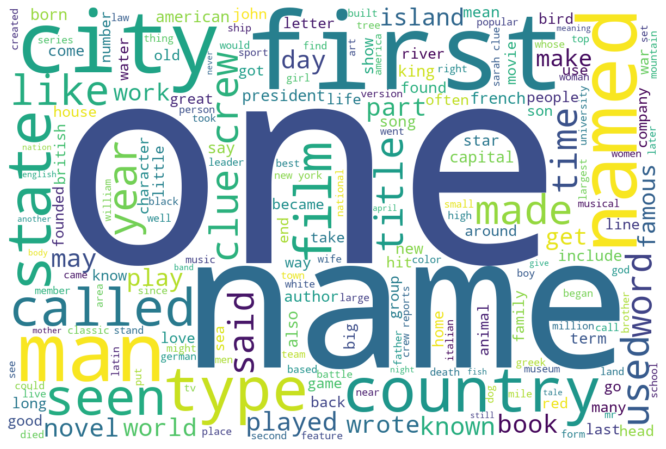

In [27]:
text = ""

for question in df.clean_question:
    text = text + question + " "
    
wordcloud = WordCloud(
    width=1200,
    height=800,
    stopwords=stopwords.words('english'),
    background_color='white'
).generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

The most common words from the `wordcloud` are non contextual i.e. they can be used in any type of question irrespective of the context of the question. These results make it a compelling reason to look into bigrams or phrazes to further analyze this point.

In [30]:
questions_overlap = []
phraze_used = set()
phraze_frequency = {}

def check_phraze(row):
    tokens = word_tokenize(row)
    split_question = [
        word for word in tokens if not word in stopwords.words('english')
    ]
    phrazes = list(bigrams(split_question))
    match_count = 0
    
    for phraze in phrazes:
        key = " ".join(phraze)
        if phraze in phraze_used:
            match_count += 1
            phraze_frequency[key] += 1
        else:
            phraze_frequency[key] = 1
        phraze_used.add(phraze)
        
    if len(split_question) > 1:
        questions_overlap.append(match_count/len(split_question))
        
df.clean_question.apply(check_phraze)
np.mean(questions_overlap)

0.1042167536217351

We see our findings to be completely different from what we acheived previously in terms of unigrams. As we cited before, single words may appear multiple times but not neccessarily in the same context.<br>

With bigrams, we partially considered (though not completely) meaning/context of some words appearing together in the questions. Just changing from unigrams to bigrams, there was a significant drop in the percentage of overlap in questions, about - 10.42% and even then this is just the proxy/estimate and not the real story.<br>

Let us visualize the frequent bigrams via a `wordcloud`.

(-0.5, 1199.5, 799.5, -0.5)

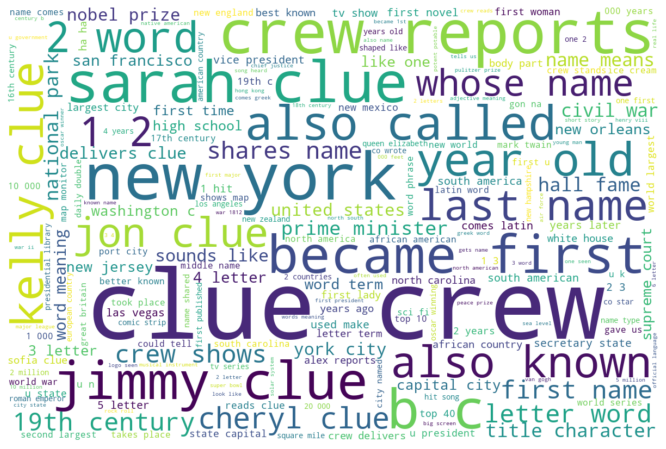

In [32]:
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white'
).generate_from_frequencies(phraze_frequency)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

Even though the bigrams gave a bit of context into the questions, we can see from the wordcloud, that bigrams are still not a perfect representation of the context of the questions and thus only show partially the repeatition of questions on the show.

The game is all about answering questions and earning money for every correct answer. So let us try to seggregate our analysis into high value questions and low value questions.<br>

Let us consider a threshold for high and low separation.

In [130]:
df.value.describe()

count    19999.000000
mean       748.336267
std        653.988299
min          0.000000
25%        400.000000
50%        600.000000
75%       1000.000000
max      12000.000000
Name: value, dtype: float64

The mean is at 748.33 rounding it to 750, this looks like a good threshold.

In [38]:
df['value_level'] = df.value.apply(lambda x: 1 if x > 750 else 0)
df.head(5)

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer,value_level
19325,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,0,"Adventurous 26th president, he was 1st to ride...",Theodore Roosevelt,adventurous 26th president he was 1st to ride...,theodore roosevelt,0
19301,10,1984-09-21,Double Jeopardy!,LABOR UNIONS,200,Notorious labor leader missing since '75,Jimmy Hoffa,notorious labor leader missing since 75,jimmy hoffa,0
19302,10,1984-09-21,Double Jeopardy!,1789,200,"Washington proclaimed Nov. 26, 1789 this first...",Thanksgiving,washington proclaimed nov 26 1789 this first...,thanksgiving,0
19303,10,1984-09-21,Double Jeopardy!,TOURIST TRAPS,200,Both Ferde Grofe' & the Colorado River dug thi...,the Grand Canyon,both ferde grofe the colorado river dug thi...,the grand canyon,0
19304,10,1984-09-21,Double Jeopardy!,LITERATURE,200,"Depending on the book, he could be a ""Jones"", ...",Tom,depending on the book he could be a jones ...,tom,0


Now we have this, let us use the set words_used that we created earlier and observe the frequency of that word for high and low value questions.

In [135]:
def observation(word):
    low_count = 0
    high_count = 0
    
    for i,row in df.iterrows():
        tokens = word_tokenize(row['clean_question'])
        if word in tokens:
            if row['value_level'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count,low_count


Let us apply the function for the first 5 words present in the set as a test.

In [154]:
observed_values = []
vocab = pd.Series(list(words_used)).sample(5,random_state=2)

for word in vocab:
    observed_values.append(observation(word))
observed_values

[(9, 7), (2, 2), (1, 0), (0, 1), (0, 2)]

In [146]:
vocab

18860           vote
4306           dined
4118          paddle
4817            tyco
15576    rattlesnake
dtype: object

Now we write a function that calculates the expected values for these observed values. The logic behind is straight forward. For each word, <br>

expected<sub>high</sub> = (high_count + low_count / total rows) * number of rows with high_value 1<br>
expected<sub>low</sub> = (high_count + low_count / total rows) * number of rows with high_value 0
<br>

Once we have these observed and expected values, for each word in our test set of 5 words, we will perform a chi-square test to find statistical significance.<br>
The null hypothesis is that there is no statistical significance between the two groups - high and low with respect to the word.<br>
The alternative hypothesis is that there exists some significance in the relationship of a word to the two groups - high and low<br>

In short what we are looking for, is to understand if the words in the questions can lead us to identify whether the question is of high-value or low-value (>750 or <=750 dollars).

In [155]:
chi_squared = {}

def chi_test(observed_values,vocab):
    high_value_count = np.count_nonzero(df.value_level == 1)
    low_value_count = np.count_nonzero(df.value_level == 0)

    total_rows = len(df)

    for word,l in zip(vocab,observed_values):
        total = sum(l)
        total_prop = total / total_rows

        expected_high = total_prop * high_value_count
        expected_low = total_prop * low_value_count

        observed = np.array([l[0],l[1]])
        expected = np.array([expected_high,expected_low])

        chi_squared[word] = chisquare(observed,expected)
    
chi_test(observed_values,vocab)
chi_squared

{'dined': Power_divergenceResult(statistic=0.06721791455120528, pvalue=0.7954314156295934),
 'paddle': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.25512076479610835),
 'rattlesnake': Power_divergenceResult(statistic=1.5443509082853344, pvalue=0.21397134128528295),
 'tyco': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353682),
 'vote': Power_divergenceResult(statistic=1.045939784130142, pvalue=0.30644404769536304)}

For every word, the p-value is much higher than the threshold - 0.05. Hence we fail to reject the null hypothesis. This means that by examining these 5 words, we found no statistical significance suggesting that these words can help us identify the type of question (high-value or low-value) we are dealing with. <br>

The above result is only for 5 terms, and maybe inconclusive of the bigger picture. Thus let us try it again with more words.

In [156]:
observed_values = []
vocab = pd.Series(list(words_used)).sample(15,random_state=4)

for word in vocab:
    observed_values.append(observation(word))
print(observed_values)
vocab

[(0, 1), (2, 3), (0, 1), (2, 1), (0, 2), (2, 1), (1, 0), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (0, 1), (0, 1), (28, 26)]


15637        tacitus
6447          falcon
26127           teri
25286       pavilion
14581        frankie
23117           vine
14232    nordlysbyen
8333          thayer
26958        tension
22655           wiig
27179        marital
20045        rebukes
18360      perpetual
18309     thermostat
21451           mile
dtype: object

In [157]:
chi_squared = {}
chi_test(observed_values,vocab)
chi_squared

{'falcon': Power_divergenceResult(statistic=0.025949785783631468, pvalue=0.8720230108094768),
 'frankie': Power_divergenceResult(statistic=1.5443509082853344, pvalue=0.21397134128528295),
 'marital': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.25512076479610835),
 'mile': Power_divergenceResult(statistic=1.5056277029766085, pvalue=0.21980747423741065),
 'nordlysbyen': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.25512076479610835),
 'pavilion': Power_divergenceResult(statistic=0.6507817652589396, pvalue=0.4198333166987812),
 'perpetual': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353682),
 'rebukes': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.25512076479610835),
 'tacitus': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353682),
 'tension': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353682),
 'teri': Power_divergenceResult(statistic=0.7721754541426672, p

For these 15 terms, the results look pretty much the same and they don't seem to show any correlation that a word helps identifying the group (high-value or low-value) of the question.

Since checking value_level with words was a dead end, let us try to analyze a relationship that might be simpler. The rounds column gives us the 4 rounds the game hosts. <br>

In [182]:
df['round'].value_counts()

Jeopardy!           9901
Double Jeopardy!    9762
Final Jeopardy!      335
Tiebreaker             1
Name: round, dtype: int64

Looking at the data and making its cross table with the value_level column, we can tell that Doube Jeopardy round holds the most high-value questions. But how do we know whether this phenomenon if just by chance (for this sample) or is this true for the population.

In [57]:
cross_table = pd.crosstab(df['round'],df['value_level'])
cross_table

value_level,0,1
round,,
Double Jeopardy!,3507,6255
Final Jeopardy!,335,0
Jeopardy!,7442,2459
Tiebreaker,1,0


For this purpose, let us perform a chi-square test using the `scipy.stats.chi2_contingency` function on the cross table.<br>
The null hypothesis is that there is no correlation between the rounds and the value level of the questions.<br>
The alternative hypothesis is that there exists some correlation between the rounds and value level of the questions.

In [189]:
chi_sq,p_value,dof,expected = chi2_contingency(cross_table)
p_value

0.0

A p_value rounded to 0.0 means we can reject the null hypothesis, and can assume the alternate hypothesis to be true i.e. there exists a correlation between the rounds and value level of the questions.

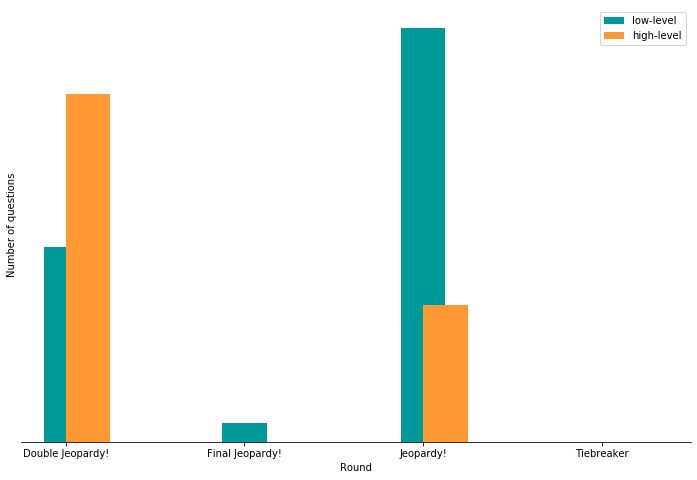

In [89]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Round')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking at the cross table and the plot, we can then conclude the direction of the difference i.e. The first round Jeopardy hosts more low-level questions whereas the second round Double Jeopardy hosts more high-level questions. The final round Final Jeopardy and the Tiebreaker round host  more of low-level questions.

The category column has the topic for the question. We have analysed which rounds have a higher chance of having high-value questions.  Now let us look into the categories (topics) and its correlation with the value levels. This was we can have an idea whether there exists a relationship/correlation between the value level and topic of question.

In [33]:
df.category.value_counts()

TELEVISION           51
U.S. GEOGRAPHY       50
LITERATURE           45
BEFORE & AFTER       40
HISTORY              40
                     ..
THEATRE               1
FINANCE HISTORY       1
THE MAP OF EUROPE     1
ON THE CALENDAR       1
ROSE BOWL HISTORY     1
Name: category, Length: 3581, dtype: int64

Similar to the approach in finding the correlation between the words and value level of the questions. We will find the observed and expected frequencies of high-value and low-value questions for each category, to this we will apply a chi-square test to determine.<br>

The null hypothesis is that there is no correlation between the level of the value and the topic of the question.<br>
The alternative hypothesis is that there is a correlation between the level of the value and the topic of the question.<br>

In simple words we are checking for each category whether it is associated mostly with high-level questions or low-level questions. We will perform this analysis on the top 10 frequent topics in the sample data.

In [39]:
catgs = df.category.value_counts().sort_values(ascending=False)[:10].index

def observed(catg):
    high_count = 0
    low_count = 0
    
    for i,row in df.iterrows():
        if row.category == catg:
            if row.value_level == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count,low_count

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
observed_values

[(9, 42),
 (20, 30),
 (21, 24),
 (24, 16),
 (12, 28),
 (18, 22),
 (12, 27),
 (15, 23),
 (14, 23),
 (10, 26)]

In [42]:
chi_squared = {}

def chi_test(observed_values,catgs):
    high_value_count = np.count_nonzero(df.value_level == 1)
    low_value_count = np.count_nonzero(df.value_level == 0)

    total_rows = len(df)

    for catg,l in zip(catgs,observed_values):
        total = sum(l)
        total_prop = total / total_rows

        expected_high = total_prop * high_value_count
        expected_low = total_prop * low_value_count

        observed = np.array([l[0],l[1]])
        expected = np.array([expected_high,expected_low])

        chi_squared[catg] = chisquare(observed,expected)
    
chi_test(observed_values,catgs)
chi_squared

{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405)}

Here we can see the majority of topics do not have p_value <= 0.05, meaning for these topics we fail to reject the null hypothesis. However, for two topics - TELEVISION and BEFORE & AFTER, the null hypothesis is rejected and hence can be said that it does have a correlation with the value levels.<br> 

We have only performed these tests for the top 10 most frequent categories (topics) in the data. Let us perform the same for the top 20 categories (topics).

In [44]:
catgs = df.category.value_counts().sort_values(ascending=False)[:20].index

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
print(catgs)
observed_values

Index(['TELEVISION', 'U.S. GEOGRAPHY', 'LITERATURE', 'BEFORE & AFTER',
       'HISTORY', 'AMERICAN HISTORY', 'AUTHORS', 'WORD ORIGINS',
       'WORLD CAPITALS', 'BODIES OF WATER', 'SPORTS', 'MAGAZINES', 'SCIENCE',
       'SCIENCE & NATURE', 'RHYME TIME', 'WORLD GEOGRAPHY', 'ANNUAL EVENTS',
       'HISTORIC NAMES', 'WORLD HISTORY', 'BIRDS'],
      dtype='object')


[(9, 42),
 (20, 30),
 (21, 24),
 (24, 16),
 (12, 28),
 (18, 22),
 (12, 27),
 (15, 23),
 (14, 23),
 (10, 26),
 (7, 29),
 (12, 23),
 (21, 14),
 (21, 14),
 (12, 23),
 (11, 22),
 (11, 21),
 (15, 17),
 (10, 22),
 (5, 26)]

In [45]:
chi_squared = {}
chi_test(observed_values,catgs)
chi_squared

{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405),
 'SPORTS': Po

We have new additions to our list of topics that have correlation with the value levels, they are - SPORTS, SCIENCE, SCIENCE & NATURE, BIRDS and the ones from previous analysis as well as this, TELEVISION and BEFORE & AFTER.<br>

Let us make a cross table for these topics, to understand the frequencies of these topics with respect to the value level.

In [90]:
catg_interest = [
    'SPORTS',
    'SCIENCE',
    'SCIENCE & NATURE',
    'BIRDS',
    'TELEVISION',
    'BEFORE & AFTER'
]

subset = df[df.category.isin(catg_interest)]
cross_table = pd.crosstab(subset.category,subset.value_level)
cross_table

value_level,0,1
category,,
BEFORE & AFTER,16,24
BIRDS,26,5
SCIENCE,14,21
SCIENCE & NATURE,14,21
SPORTS,29,7
TELEVISION,42,9


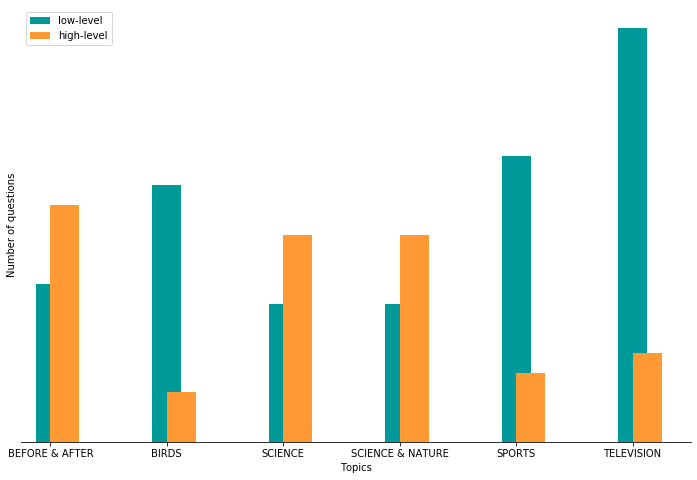

In [91]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Topics')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking into the cross table, the plot and the p_values obtained from before, we can say that the topics SPORTS, TELEVISION, BIRDS have a higher chance of being low-level questions, whereas the topics BEFORE & AFTER, SCIENCE and SCIENCE & NATURE have a higher chance of being high-level questions.

From our analysis, we can conclude :-

    1. The answers are hardly hidden in the questions and hence the participant has to be revised with all categories (topics).
    
    2. The repetition of questions is rare, the participant must not rely on reading previous questions only to win the game.
    
    3. No relationship was found between the level of the question (>750 or <750 dollars) and the words present in the questions. Thus the participant cannot estimate the level of the question with respect to words in  the question.
    
    4. The first round, Jeopardy! hosts mostly low-level (<750 dollars) questions. Whereas the second round    Double Jeopardy! hosts high-level (>750 dollars) questions. Participant's aim to win more money can utilize these findings and play accordingly.
    
    5. The categories (topics) - SPORTS, TELEVISION and BIRDS have a higher chance of having low-level (<750 dollars) questions, whereas the categories (topics) BEFORE & AFTER, SCIENCE and SCIENCE & NATURE have a highe chance of having high-level (> 750 dollars) questions. 
    
From the above conclusions, the participant can accordingly prepare and choose to answer questions in the game in order to win more money and overall be successful in the game.